In [1]:
import numpy as np
import scipy.optimize as spo
import pickle
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree, metrics, ensemble, naive_bayes
from PIL import Image

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport sample_patches
%aimport gradient
%aimport autoencoder
%aimport display_layer

In [3]:
testFile = open('data/test.pk', 'rb')
test = pickle.load(testFile)
testFile.close()

In [4]:
trainFile = open('data/train.pk', 'rb')
train = pickle.load(trainFile)
trainFile.close()

In [ ]:
unlabeled = np.empty((5 * 20000, 27648))
for i in range(5):
    unlFile = open('data/X' + str(i + 1) + '.pk', 'rb')
    unlabeled[20000 * i: 20000 * (i + 1)] = pickle.load(unlFile)
    unlFile.close()

## Подготовка

In [ ]:
# display_layer.display_layer(unlabeled, 'pic/unlabeled.jpg') # save images in one file

In [ ]:
# patches = sample_patches.sample_patches_raw(unlabeled) # make patches without normalizing
# display_layer.display_layer(patches, 'pic/patches.png') # save patches to file

In [ ]:
# patches_normal = sample_patches.normalize_data(patches) # normalize patches (not using sample_patch func for testing)
# display_layer.display_layer(patches_normal * 255, 'pic/patches_normal.png') # save normalized patches

In [ ]:
# gradient.check_gradient() # check compute_gradient function

#### Выделение патчей

In [6]:
patches_normal = sample_patches.sample_patches(unlabeled)
del(unlabeled)
display_layer.display_layer(patches_normal * 255, 'pic/patches_normal.png') # save normalized patches

#### Проверка градиента функции потерь

In [38]:
# Check gradient
N = 1000
hs = [10, 8, 10]
vs = 25
t = autoencoder.initialize(np.array(hs), vs)
J = lambda x : autoencoder.autoencoder_loss(patches_normal[:N, :vs], x, vs, np.array(hs), onlyJ=True)
gr = gradient.compute_gradient(J, t)
%time grad = autoencoder.autoencoder_loss(patches_normal[:N, :vs], t, vs, np.array(hs))
np.max(np.abs(gr - grad[1]))

CPU times: user 4.07 ms, sys: 714 µs, total: 4.79 ms
Wall time: 4.5 ms


1.036033250301216e-07

## Обучение разреженного автокодировщика

In [7]:
loss = lambda x : autoencoder.autoencoder_loss(patches_normal, x, 192, np.array([75]), beta=0.3)

In [8]:
t = autoencoder.initialize(np.array([75]), 192)

In [9]:
%time minim = spo.minimize(loss, t, method='L-BFGS-B', jac=True, options={'maxiter': 10000, 'disp': True})

CPU times: user 46min 50s, sys: 12min 10s, total: 59min
Wall time: 43min 34s


In [12]:
# np.savetxt("theta.csv", minim.x, delimiter=",") # backup optimal theta
import pandas
theta = pandas.read_csv('theta.csv', header=None).values.ravel() # read backed up theta

## Визуализация

In [15]:
i = np.copy(minim.x)
i = i[:192 * 75].reshape(192, -1)
i /= np.sqrt(np.sum(i ** 2, axis=0))
imax = np.max(i, axis=0)
imin = np.min(i, axis=0)
img = ((i - imin) / (imax - imin))

In [16]:
display_layer.display_layer(img.T * 255, 'pic/hidden.png') # pic of hidden layer

## Обучение классификатора на данных сокращенной размерности

Для классификации был выбран метод RandomForest, так как этот классификатор дает самую большую точность из всех перепробованных (SVM-Linear, SVM-RBF, kNN, DesTree) и работает быстро

In [14]:
def getPachedData(train, test, theta, patchStep=6, visible_size=192, hidden_size=np.array([75]), layer_number=2):
    oneRowPatchNum = (96 - 8) // patchStep + 1
    patchNum = oneRowPatchNum ** 2 # * (96 // 8)

    patchSize = hidden_size[layer_number - 2]
    
    patchedTrain = np.empty((train.shape[0], patchSize * patchNum))
    patchedTest = np.empty((test.shape[0], patchSize * patchNum))
    imgTrain = train.reshape(train.shape[0], 96, 96, 3)
    imgTest = test.reshape(test.shape[0], 96, 96, 3)
    
    for i in range(patchNum):
        row = (i // oneRowPatchNum) * patchStep # * 8
        column = (i % oneRowPatchNum) * patchStep
        patchedTrain[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
            theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
            imgTrain[:, row: row + 8, column: column + 8].reshape(-1, 192)))

        patchedTest[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
            theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
            imgTest[:, row: row + 8, column: column + 8].reshape(-1, 192)))
    return patchedTrain, patchedTest

In [15]:
rForest = sklearn.ensemble.RandomForestClassifier()

In [12]:
rForest.fit(train['X'], train['y'].ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
predLbls = rForest.predict(test['X'])

In [14]:
print("Точность на исходных данных:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на исходных данных: 0.333375


In [16]:
nb = sklearn.naive_bayes.GaussianNB()

In [17]:
nb.fit(train['X'], train['y'].ravel())

GaussianNB()

In [18]:
predLbls = nb.predict(test['X'])

In [19]:
print("Точность на исходных данных (байесовский классификатор):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на исходных данных (байесовский классификатор): 0.323875


#### Сеть с одним скрытым слоем

In [41]:
%time patchedTrain, patchedTest = getPachedData(train['X'], test['X'], theta, patchStep=10)

CPU times: user 11.2 s, sys: 3.1 s, total: 14.3 s
Wall time: 11.9 s


In [42]:
rForest.fit(patchedTrain, train['y'].ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
predLbls = rForest.predict(patchedTest)

In [22]:
print("Точность на данных сокращенной размерности при шаге 4:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 4: 0.342375


In [30]:
print("Точность на данных сокращенной размерности при шаге 6:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 6: 0.328


In [44]:
print("Точность на данных сокращенной размерности при шаге 10:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 10: 0.32425


In [45]:
nb.fit(patchedTrain, train['y'].ravel())

GaussianNB()

In [46]:
predLbls = nb.predict(patchedTest)

In [25]:
print("Точность на данных сокращенной размерности при шаге 4 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 4 (NB): 0.424375


In [33]:
print("Точность на данных сокращенной размерности при шаге 6 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 6 (NB): 0.41775


In [47]:
print("Точность на данных сокращенной размерности при шаге 10 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 10 (NB): 0.39525


In [48]:
del(patchedTrain, patchedTest)

#### Сеть с тремя скрытыми слоями

In [16]:
# import pandas
# theta = pandas.read_csv('theta.csv', header=None).values.ravel() # read backed up theta

In [68]:
patchStep = 10
visible_size = 192
hidden_size = np.array([108, 75, 108])
layer_number = 3
oneRowPatchNum = (96 - 8) // patchStep + 1
patchNum = oneRowPatchNum ** 2 # * (96 // 8)

patchSize = hidden_size[layer_number - 2]
    
patchedTrain = np.empty((train['X'].shape[0], patchSize * patchNum))
patchedTest = np.empty((test['X'].shape[0], patchSize * patchNum))
imgTrain = train['X'].reshape(train['X'].shape[0], 96, 96, 3)
imgTest = test['X'].reshape(test['X'].shape[0], 96, 96, 3)

for i in range(patchNum):
    row = (i // oneRowPatchNum) * patchStep # * 8
    column = (i % oneRowPatchNum) * patchStep
    patchedTrain[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
        theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
        imgTrain[:, row: row + 8, column: column + 8].reshape(-1, 192)))

    patchedTest[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
        theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
        imgTest[:, row: row + 8, column: column + 8].reshape(-1, 192)))

In [69]:
rForest.fit(patchedTrain, train['y'].ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
predLbls = rForest.predict(patchedTest)

In [55]:
print("Точность на данных сокращенной размерности при шаге 4:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 4: 0.293625


In [63]:
print("Точность на данных сокращенной размерности при шаге 6:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 6: 0.286625


In [71]:
print("Точность на данных сокращенной размерности при шаге 10:", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 10: 0.274375


In [72]:
nb.fit(patchedTrain, train['y'].ravel())

GaussianNB()

In [73]:
predLbls = nb.predict(patchedTest)

In [58]:
print("Точность на данных сокращенной размерности при шаге 4 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 4 (NB): 0.328625


In [66]:
print("Точность на данных сокращенной размерности при шаге 6 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 6 (NB): 0.319875


In [74]:
print("Точность на данных сокращенной размерности при шаге 10 (NB):", sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls))

Точность на данных сокращенной размерности при шаге 10 (NB): 0.309375


In [75]:
del(patchedTest, patchedTrain)

### Зависимость качества классификации от количества патчей

In [21]:
res = np.zeros(6)

In [52]:
patches_normal = sample_patches.sample_patches(unlabeled, 6000)
del(unlabeled)
# display_layer.display_layer(patches_normal * 255, 'pic/patches_normal.png') # save normalized patches

In [11]:
loss = lambda x : autoencoder.autoencoder_loss(patches_normal, x, 192, np.array([75]), beta=0.3)

In [53]:
t = autoencoder.initialize(np.array([75]), 192)

In [54]:
%time minim = spo.minimize(loss, t, method='L-BFGS-B', jac=True, options={'maxiter': 10000, 'disp': True})

CPU times: user 32min 14s, sys: 9min 2s, total: 41min 17s
Wall time: 36min 54s


In [55]:
i = np.copy(minim.x)
i = i[:192 * 75].reshape(192, -1)
i /= np.sqrt(np.sum(i ** 2, axis=0))
imax = np.max(i, axis=0)
imin = np.min(i, axis=0)
img = ((i - imin) / (imax - imin))
display_layer.display_layer(img.T * 255, 'pic/hidden_6000.png') # pic of hidden layer

In [56]:
theta = minim.x
patchStep = 4
visible_size = 192
hidden_size = np.array([75])
layer_number = 2
oneRowPatchNum = (96 - 8) // patchStep + 1
patchNum = oneRowPatchNum ** 2 # * (96 // 8)

patchSize = hidden_size[layer_number - 2]
    
patchedTrain = np.empty((train['X'].shape[0], patchSize * patchNum))
patchedTest = np.empty((test['X'].shape[0], patchSize * patchNum))
imgTrain = train['X'].reshape(train['X'].shape[0], 96, 96, 3)
imgTest = test['X'].reshape(test['X'].shape[0], 96, 96, 3)

for i in range(patchNum):
    row = (i // oneRowPatchNum) * patchStep # * 8
    column = (i % oneRowPatchNum) * patchStep
    patchedTrain[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
        theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
        imgTrain[:, row: row + 8, column: column + 8].reshape(-1, 192)))

    patchedTest[:, patchSize * i: patchSize * (i + 1)] = autoencoder.autoencoder_transform(
        theta, visible_size, hidden_size, layer_number, sample_patches.normalize_data(
        imgTest[:, row: row + 8, column: column + 8].reshape(-1, 192)))
del(imgTrain, imgTest)

In [57]:
rForest.fit(patchedTrain, train['y'].ravel())

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [58]:
predLbls = rForest.predict(patchedTest)

In [59]:
res[4] = sklearn.metrics.accuracy_score(test['y'].ravel(), predLbls)

In [24]:
print("Точность на 100 патчах:", res[0])

Точность на 100 патчах: 0.326125


In [33]:
print("Точность на 500 патчах:", res[1])

Точность на 500 патчах: 0.327375


In [42]:
print("Точность на 1000 патчах:", res[2])

Точность на 1000 патчах: 0.325625


In [51]:
print("Точность на 3000 патчах:", res[3])

Точность на 3000 патчах: 0.326125


In [60]:
print("Точность на 6000 патчах:", res[4])

Точность на 6000 патчах: 0.337375


In [61]:
res[5] = 0.345875

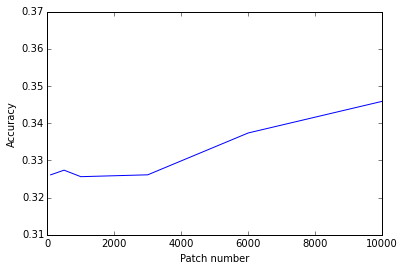

In [4]:
plt.ylim(0.31, 0.37)
plt.ylabel('Accuracy')
plt.xlabel('Patch number')
plt.plot(res)